## **Model Evaluation Analysis Report** ##

---
**Detailed Performance Metrics and Visualizations for Checkpoint Evaluation**

---
*Detailed Performance Metrics and Visualizations for Checkpoint Evaluation*


# ==========================================================================
# Cell 1: Imports, Setup, Configuration
# ==========================================================================

In [1]:
print("[INFO] Starting script: Loading libraries and configuring environment...")

import os
import glob
import ctypes
import re
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, mixed_precision
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score,
    f1_score, accuracy_score, mean_squared_error, mean_absolute_error
)
import seaborn as sns # For plotting confusion matrix nicely
import traceback      # For printing detailed errors on exceptions
import time           # To add timestamp to filenames

print(f"[INFO] Script execution started at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"[INFO] TensorFlow Version: {tf.__version__}")
print(f"[INFO] NumPy Version: {np.__version__}")
print(f"[INFO] Pandas Version: {pd.__version__}")

# --- Mixed Precision Policy ---
try:
    mixed_precision.set_global_policy('mixed_float16')
    print("[INFO] Mixed precision ('mixed_float16') policy set globally.")
except Exception as e:
    print(f"[WARNING] Could not set mixed precision policy: {e}. Proceeding without.")

# --- ZLIB DLL Fix for Windows (Optional) ---
try:
    conda_prefix = os.environ.get('CONDA_PREFIX', None)
    dll_path = None
    if conda_prefix:
        potential_path = os.path.join(conda_prefix, 'Library', 'bin', 'zlibwapi.dll')
        if os.path.exists(potential_path):
            dll_path = potential_path
            print(f"[INFO] Found zlibwapi.dll in Conda environment: {dll_path}")
    if dll_path:
        ctypes.CDLL(dll_path)
        print("[INFO] Successfully loaded zlibwapi.dll.")
    else:
        print("[INFO] zlibwapi.dll not found or CONDA_PREFIX not set. Skipping load.")
except Exception as e:
    print(f"[INFO] Optional zlibwapi.dll loading skipped or failed (often okay): {e}")

# --- GPU Configuration ---
print("[INFO] Detecting and configuring GPUs...")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"[INFO] Using {len(gpus)} Physical GPU(s) -> {len(logical_gpus)} Logical GPU(s).")
        details = tf.config.experimental.get_device_details(gpus[0])
        print(f"       GPU 0 Name: {details.get('device_name', 'N/A')}")
        print(f"       Compute Capability: {details.get('compute_capability', 'N/A')}")
    except RuntimeError as e:
        print(f"[ERROR] GPU configuration failed: {e}. Using CPU.")
        gpus = []
else:
    print("[WARNING] No GPU detected by TensorFlow. Using CPU (may be slow).")

# --- Configuration Parameters ---
print("[CONFIG] Setting configuration parameters...")
# <<< === NEW DATA DIRECTORY === >>>
DATA_DIR        = r"C:\college\CV\COSMOS\6C_data"
# <<< === TARGET CHECKPOINT (ensure this is correct) === >>>
CHECKPOINT_PATH = r"C:\college\CV\COSMOS\checkpoints\model_epoch_11.h5"
# --- Parameters that MUST match model training ---
SEQ_LEN         = 4
PATCH_SIZE      = 32
# --- Evaluation settings ---
EVAL_BATCH_SIZE = 32 # Adjust based on GPU memory
# <<< === USE FULL VALIDATION SET === >>>
EVAL_SUBSET_FRACTION = 1.0 # Evaluate on 100% of validation data from DATA_DIR
# --- Label Generation Thresholds (MUST match training) ---
THRESHOLD       = 265.0
CV_THRESHOLD    = 260.0
FOG_THRESHOLD   = 270.0

print(f"[CONFIG] Data Directory: {DATA_DIR}")
print(f"[CONFIG] Checkpoint for evaluation: {CHECKPOINT_PATH}")
print(f"[CONFIG] Input Sequence Length: {SEQ_LEN}")
print(f"[CONFIG] Patch Size: {PATCH_SIZE}x{PATCH_SIZE}")
print(f"[CONFIG] Evaluation Batch Size: {EVAL_BATCH_SIZE}")
print(f"[CONFIG] Evaluation subset fraction: {EVAL_SUBSET_FRACTION:.2f} ({EVAL_SUBSET_FRACTION*100:.0f}%)")

# --- Validate Configuration ---
if not os.path.isdir(DATA_DIR): raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")
if not os.path.exists(CHECKPOINT_PATH): raise FileNotFoundError(f"Checkpoint file not found: {CHECKPOINT_PATH}")
if not 0.0 < EVAL_SUBSET_FRACTION <= 1.0: raise ValueError("EVAL_SUBSET_FRACTION must be > 0.0 and <= 1.0.")

# --- Load File Sequences ---
print("[INFO] Scanning for HDF5 files and creating sequences from new data path...")
all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.h5")))
if not all_files: raise FileNotFoundError(f"No HDF5 files ('*.h5') found in DATA_DIR: {DATA_DIR}")
sequences = [all_files[i:i + SEQ_LEN + 1] for i in range(len(all_files) - SEQ_LEN)]
if not sequences: raise ValueError(f"Not enough files ({len(all_files)}) to form sequences of length {SEQ_LEN + 1}.")
print(f"[INFO] Found {len(all_files)} files, created {len(sequences)} total sequences.")

# --- Define Train/Validation Split & Select Evaluation Subset ---
split_index = int((1.0 - 0.1) * len(sequences)) # Default: 90% train / 10% validation split
full_eval_seqs = sequences[split_index:]
if not full_eval_seqs: raise ValueError("No evaluation sequences found after 90/10 split. Is the dataset large enough?")
# Apply the fraction (now 1.0) to get the subset we will actually process
num_eval_subset = max(1, int(EVAL_SUBSET_FRACTION * len(full_eval_seqs)))
eval_seqs_subset = full_eval_seqs[:num_eval_subset] # Use the calculated number of sequences
print(f"[INFO] Total sequences split: {len(sequences[:split_index])} train, {len(full_eval_seqs)} validation.")
print(f"[INFO] Subset for evaluation: {len(eval_seqs_subset)} sequences ({EVAL_SUBSET_FRACTION*100:.1f}% of validation split).")
if EVAL_SUBSET_FRACTION == 1.0:
    print("[INFO] ==> Evaluating on the FULL validation set defined by the 90/10 split.")
else:
    print("[INFO] ==> Evaluating on a PARTIAL validation set.")


# --- Helper Function: Extract Epoch ---
def get_epoch_from_filename(fname):
    """Extracts epoch number from '..._epoch_NUMBER.h5'."""
    match = re.search(r"epoch_(\d+)", os.path.basename(fname))
    return int(match.group(1)) if match else -1


[INFO] Starting script: Loading libraries and configuring environment...
[INFO] Script execution started at: 2025-05-03 18:13:30
[INFO] TensorFlow Version: 2.10.0
[INFO] NumPy Version: 1.26.4
[INFO] Pandas Version: 2.2.3
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6
[INFO] Mixed precision ('mixed_float16') policy set globally.
[INFO] Found zlibwapi.dll in Conda environment: C:\Users\dhanu\.conda\envs\w\Library\bin\zlibwapi.dll
[INFO] Successfully loaded zlibwapi.dll.
[INFO] Detecting and configuring GPUs...
[INFO] Using 1 Physical GPU(s) -> 1 Logical GPU(s).
       GPU 0 Name: NVIDIA GeForce RTX 3060 Laptop GPU
       Compute Capability: (8, 6)
[CONFIG] Setting configuration parameters...
[CONFIG] Data Directory: C:\college\CV\COSMOS\6C_data
[CONFIG] Checkpoint for evaluation: C:\col

# ==========================================================================
# Cell 2: Evaluation Data Loader (WITH Random Cropping)
# ==========================================================================

In [2]:
print("\n[INFO] Defining data loading and processing functions...")
print("[INFO] IMPORTANT: Assumes HDF5 files in the new data path have the expected internal structure.")

def load_eval_data(file_path_sequence):
    """
    Loads data for a single sequence (SEQ_LEN inputs + 1 target).
    Args: file_path_sequence (list): List of (SEQ_LEN + 1) file paths.
    Returns: tuple (X, y) or (None, None) on error.
    NOTE: Assumes specific HDF5 keys (IMG_TIR1, IMG_TIR1_TEMP etc.) exist.
    """
    if len(file_path_sequence) != SEQ_LEN + 1: return None, None
    input_frames = []
    for i, fp in enumerate(file_path_sequence[:SEQ_LEN]):
        try:
            with h5py.File(fp, 'r') as f:
                cnt1 = f['IMG_TIR1'][0][...]
                cnt2 = f['IMG_TIR2'][0][...]
                cnt_wv = f['IMG_WV'][0][...]
                cnt_mir = f['IMG_MIR'][0][...]
                cnt_vis = f['IMG_VIS'][0][...]
                lut1 = f['IMG_TIR1_TEMP'][:]
                lut2 = f['IMG_TIR2_TEMP'][:]
                lut_wv = f['IMG_WV_TEMP'][:]
                lut_mir = f['IMG_MIR_TEMP'][:]
                lut_vis = f['IMG_VIS_ALBEDO'][:]
                bt1, bt2 = lut1[cnt1], lut2[cnt2]
                wv, mir, vis = lut_wv[cnt_wv], lut_mir[cnt_mir], lut_vis[cnt_vis]
                # Assuming channel order [BT1, BT2, WV, MIR, VIS] and normalization /300.0
                frame_data = np.stack([bt1, bt2, wv, mir, vis], axis=-1) / 300.0
                input_frames.append(frame_data)
        except Exception as e:
            print(f"[ERROR] Data Loader (Input): Failed loading {fp}: {e}. Check file structure/keys.")
            return None, None
    if len(input_frames) != SEQ_LEN: return None, None
    X = np.stack(input_frames, axis=0).astype(np.float32)

    target_fp = file_path_sequence[-1]
    try:
        with h5py.File(target_fp, 'r') as f:
            cnt1_t, cnt2_t = f['IMG_TIR1'][0][...], f['IMG_TIR2'][0][...]
            cnt_wv_t, cnt_mir_t = f['IMG_WV'][0][...], f['IMG_MIR'][0][...]
            lut1_t, lut2_t = f['IMG_TIR1_TEMP'][:], f['IMG_TIR2_TEMP'][:]
            lut_wv_t, lut_mir_t = f['IMG_WV_TEMP'][:], f['IMG_MIR_TEMP'][:]
            bt1_t, bt2_t = lut1_t[cnt1_t], lut2_t[cnt2_t]
            wv_t, mir_t = lut_wv_t[cnt_wv_t], lut_mir_t[cnt_mir_t]

            # Generate labels (MUST match training logic & thresholds)
            cloud_label = (bt1_t < THRESHOLD).astype(np.float32)[..., np.newaxis]
            convective_label = (bt1_t < CV_THRESHOLD).astype(np.float32)[..., np.newaxis]
            fog_label = (mir_t < FOG_THRESHOLD).astype(np.float32)[..., np.newaxis]
            moisture_label = (wv_t / 300.0).astype(np.float32)[..., np.newaxis] # Norm
            thermo_contrast_label = ((bt2_t - bt1_t) / 100.0).astype(np.float32)[..., np.newaxis] # Norm/Scale
            last_mean_bt1_norm = np.mean(bt1_t / 300.0)
            first_mean_bt1_norm = np.mean(X[0, ..., 0]) # BT1 of first input frame
            temp_trend_label = np.array([last_mean_bt1_norm - first_mean_bt1_norm], dtype=np.float32)

            y = {'cloud': cloud_label, 'convective': convective_label, 'fog': fog_label,
                 'moisture': moisture_label, 'thermo_contrast': thermo_contrast_label,
                 'temp_trend': temp_trend_label}
            return X, y
    except Exception as e:
        print(f"[ERROR] Data Loader (Target): Failed loading {target_fp}: {e}. Check file structure/keys.")
        return None, None

def random_crop(X_full, y_full_dict, patch_size=PATCH_SIZE):
    """
    Applies random cropping to match training data generation.
    Returns (X_patch, y_patch_dict) or (None, None) on error/incompatibility.
    """
    if X_full is None: return None, None
    H, W = X_full.shape[1], X_full.shape[2]
    if H < patch_size or W < patch_size:
        # Print warning only once per dimension mismatch type? Or let it repeat?
        # print(f"[WARNING] Cropping: Image dimensions ({H}x{W}) < patch size ({patch_size}). Skipping sample.")
        return None, None # Skip if image is too small for the patch
    max_i, max_j = H - patch_size, W - patch_size
    i, j = np.random.randint(0, max_i + 1), np.random.randint(0, max_j + 1)
    X_patch = X_full[:, i:i + patch_size, j:j + patch_size, :]
    y_patch_dict = {}
    for task_name, target_data in y_full_dict.items():
        # Crop only if it's a spatial map matching the full image dimensions
        if target_data.ndim >= 2 and target_data.shape[0] == H and target_data.shape[1] == W:
            y_patch_dict[task_name] = target_data[i:i + patch_size, j:j + patch_size]
        else:
            y_patch_dict[task_name] = target_data # Keep non-spatial targets
    return X_patch, y_patch_dict

def evaluation_generator(sequences_to_process):
    """
    Python generator yielding (X_patch, y_patch_dict) tuples for the evaluation subset.
    Handles potential errors during loading or cropping by skipping problematic sequences.
    """
    print(f"[Generator] Initializing evaluation generator for {len(sequences_to_process)} sequences...")
    num_yielded = 0
    sequences_copy = list(sequences_to_process)
    while num_yielded < len(sequences_to_process):
        np.random.shuffle(sequences_copy)
        initial_yields_in_loop = num_yielded
        processed_in_loop = 0
        for file_seq in sequences_copy:
            processed_in_loop += 1
            X_full, y_full = load_eval_data(file_seq)
            if X_full is not None and y_full is not None:
                X_patch, y_patch = random_crop(X_full, y_full, patch_size=PATCH_SIZE)
                if X_patch is not None and y_patch is not None:
                    yield X_patch, y_patch
                    num_yielded += 1
                    if num_yielded >= len(sequences_to_process):
                        print(f"\n[Generator] Successfully yielded {num_yielded} samples. Target reached. Generator finished.")
                        return
        # Check if the generator is stuck (made no progress in a full loop)
        if num_yielded == initial_yields_in_loop and num_yielded < len(sequences_to_process) and processed_in_loop > 0:
            print(f"\n[Generator WARNING] Looped through {processed_in_loop} sequences but failed to yield more valid samples ({num_yielded}/{len(sequences_to_process)} yielded). Check data integrity or cropping logic. Stopping generator.")
            return
        # Handle case where sequence list might be empty initially
        if processed_in_loop == 0:
            print("\n[Generator WARNING] Sequence list was empty. Generator finished without yielding.")
            return


# --- Define TensorFlow Dataset Output Signature ---
print("[INFO] Defining TensorFlow Dataset structure (output signature)...")
eval_output_signature = (
    tf.TensorSpec(shape=(SEQ_LEN, PATCH_SIZE, PATCH_SIZE, 5), dtype=tf.float32), # Input X patch
    { # Output Y patch dictionary
        'cloud': tf.TensorSpec(shape=(PATCH_SIZE, PATCH_SIZE, 1), dtype=tf.float32),
        'convective': tf.TensorSpec(shape=(PATCH_SIZE, PATCH_SIZE, 1), dtype=tf.float32),
        'fog': tf.TensorSpec(shape=(PATCH_SIZE, PATCH_SIZE, 1), dtype=tf.float32),
        'moisture': tf.TensorSpec(shape=(PATCH_SIZE, PATCH_SIZE, 1), dtype=tf.float32),
        'thermo_contrast': tf.TensorSpec(shape=(PATCH_SIZE, PATCH_SIZE, 1), dtype=tf.float32),
        'temp_trend': tf.TensorSpec(shape=(1,), dtype=tf.float32)
    }
)
print("[INFO] Output signature defined.")

# --- Create and Optimize TensorFlow Dataset ---
print("[INFO] Creating TensorFlow Dataset from generator...")
eval_ds = tf.data.Dataset.from_generator(
    lambda: evaluation_generator(eval_seqs_subset), # Use the selected subset
    output_signature=eval_output_signature
).cache().batch(EVAL_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(f"[INFO] Evaluation tf.data.Dataset created.")
print(f"       Target Samples (Patches): {len(eval_seqs_subset)}")
print(f"       Batch Size: {EVAL_BATCH_SIZE}")
print(f"       Output Element Spec: {eval_ds.element_spec}") # Can be verbose



[INFO] Defining data loading and processing functions...
[INFO] IMPORTANT: Assumes HDF5 files in the new data path have the expected internal structure.
[INFO] Defining TensorFlow Dataset structure (output signature)...
[INFO] Output signature defined.
[INFO] Creating TensorFlow Dataset from generator...
[INFO] Evaluation tf.data.Dataset created.
       Target Samples (Patches): 21
       Batch Size: 32
       Output Element Spec: (TensorSpec(shape=(None, 4, 32, 32, 5), dtype=tf.float32, name=None), {'cloud': TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), 'convective': TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), 'fog': TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), 'moisture': TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), 'thermo_contrast': TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), 'temp_trend': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)})


# ==========================================================================
# Cell 3: Evaluate Single Checkpoint on the Selected Dataset
# ==========================================================================


In [3]:
print("\n" + "="*60)
print("[EVAL] Starting Model Evaluation")
print(f"[EVAL] Using data derived from: {DATA_DIR}")
print(f"[EVAL] Evaluating on {len(eval_seqs_subset)} sequences ({EVAL_SUBSET_FRACTION*100:.1f}% of validation split)")
print("="*60)

evaluation_results = {}
ckpt_path_to_eval = CHECKPOINT_PATH
epoch_number = get_epoch_from_filename(ckpt_path_to_eval)
epoch_str_display = f"Epoch {epoch_number}" if epoch_number != -1 else "Epoch Unknown"
print(f"[EVAL] Target Checkpoint: {os.path.basename(ckpt_path_to_eval)} ({epoch_str_display})")

# Define variables needed later in visualization (Cell 5)
predictions = None
true_labels = None
model = None
actual_num_samples_for_metrics = 0

try:
    # --- Load Model ---
    print("[EVAL] Loading model architecture and weights...")
    # compile=True attempts to load optimizer state and compiled metrics/loss.
    # If loading fails, try compile=False (only loads weights+architecture).
    model = tf.keras.models.load_model(ckpt_path_to_eval, compile=True)
    print("[EVAL] Model loaded successfully.")

    # --- Calculate Steps ---
    eval_steps = int(np.ceil(len(eval_seqs_subset) / EVAL_BATCH_SIZE))
    print(f"[EVAL] Calculated evaluation steps: {eval_steps}")
    if eval_steps == 0:
        raise ValueError("[ERROR] Calculated 0 evaluation steps. Check subset size and batch size.")

    # --- Generate Predictions ---
    print(f"[EVAL] Generating predictions using model.predict() across {eval_steps} step(s)... (This may take time)")
    # Note: Requires significant RAM if the evaluation set is very large.
    predictions = model.predict(eval_ds, steps=eval_steps, verbose=1)
    print(f"[EVAL] Predictions generated.")

    # --- Gather Ground Truth Labels ---
    print(f"[EVAL] Gathering ground truth labels corresponding to predictions...")
    # Initialize dictionary to hold lists of batches for each task
    true_labels = {task_name: [] for task_name in model.output_names}
    num_labels_gathered = 0
    # Iterate through the dataset again, ensuring we take the same number of steps
    for _, y_batch_dict in tqdm(eval_ds.take(eval_steps), desc="[EVAL] Gathering Labels", total=eval_steps, unit="batch"):
        batch_size_current = 0
        first_task_key = model.output_names[0] # Use first task to get batch size
        if first_task_key in y_batch_dict:
            batch_size_current = y_batch_dict[first_task_key].shape[0]
        # Append labels for all tasks
        for task_name in true_labels.keys():
            if task_name in y_batch_dict:
                true_labels[task_name].append(y_batch_dict[task_name].numpy())
            else: print(f"[WARNING] Task '{task_name}' missing in labels batch.")
        num_labels_gathered += batch_size_current
    print(f"[EVAL] Finished gathering labels. Total samples gathered: {num_labels_gathered}")

    # --- Concatenate Label Batches ---
    print("[EVAL] Concatenating gathered label batches... (May require significant RAM)")
    num_pred_samples = 0 # Get count from prediction structure
    concatenated_label_shapes = {}
    try:
        for task_name in true_labels.keys():
            if true_labels[task_name]:
                # This step can cause MemoryError for large datasets
                true_labels[task_name] = np.concatenate(true_labels[task_name], axis=0)
                concatenated_label_shapes[task_name] = true_labels[task_name].shape
                if task_name == model.output_names[0]:
                    num_pred_samples = predictions[task_name].shape[0]
            else:
                print(f"[WARNING] No labels gathered for task '{task_name}'. Setting to None.")
                true_labels[task_name] = None
        print("[EVAL] Label concatenation complete.")
        # for task_name, shape in concatenated_label_shapes.items():
        #      print(f"       Final shape for '{task_name}' labels: {shape}")

    except MemoryError as e:
        print(f"\n[FATAL ERROR] MemoryError during label concatenation for task '{task_name}'.")
        print("             The evaluation dataset is likely too large for available RAM.")
        print("             Try reducing EVAL_SUBSET_FRACTION significantly (e.g., 0.1 or lower).")
        raise e # Stop execution
    except ValueError as e:
        print(f"[ERROR] Failed concatenate labels for '{task_name}': {e}. Check batch shapes consistency.")
        true_labels[task_name] = None # Invalidate this task's labels

    # --- Verify Alignment ---
    print(f"[EVAL] Verifying alignment: Predictions={num_pred_samples}, Labels={num_labels_gathered}")
    if num_pred_samples != num_labels_gathered:
        print(f"[WARNING] Mismatch found. Truncating to {min(num_pred_samples, num_labels_gathered)} samples.")
        min_samples = min(num_pred_samples, num_labels_gathered)
        actual_num_samples_for_metrics = min_samples
        for task_name in predictions.keys():
            if predictions[task_name] is not None: predictions[task_name] = predictions[task_name][:min_samples]
            if task_name in true_labels and true_labels[task_name] is not None: true_labels[task_name] = true_labels[task_name][:min_samples]
    elif num_pred_samples == 0 and num_labels_gathered == 0:
        print("[WARNING] Both predictions and labels appear empty. No metrics possible.")
        actual_num_samples_for_metrics = 0
    else:
        print("[INFO] Prediction and label counts match.")
        actual_num_samples_for_metrics = num_pred_samples

    # --- Calculate Metrics ---
    if actual_num_samples_for_metrics > 0:
        print(f"\n[EVAL] Calculating metrics based on {actual_num_samples_for_metrics} aligned samples...")
        epoch_metrics_results = {'epoch': epoch_number}
        for task_name in model.output_names:
            print(f"    Processing Task: '{task_name}'")
            if task_name not in predictions or predictions[task_name] is None or task_name not in true_labels or true_labels[task_name] is None:
                print(f"      Skipping task '{task_name}': Missing predictions or labels."); continue
            y_true_task, y_pred_task = true_labels[task_name], predictions[task_name]
            if y_true_task.shape[0] != actual_num_samples_for_metrics or y_pred_task.shape[0] != actual_num_samples_for_metrics:
                 print(f"      Skipping task '{task_name}': Shape mismatch after truncation/checks."); continue

            is_classification = task_name in ['cloud', 'convective', 'fog']
            task_type_str = 'Classification' if is_classification else 'Regression'
            print(f"      Task type: {task_type_str}")
            try:
                if is_classification:
                    # Flattening large arrays can consume significant memory
                    y_true_flat, y_pred_flat = y_true_task.flatten(), y_pred_task.flatten()
                    y_pred_binary = (y_pred_flat >= 0.5).astype(int)
                    accuracy = accuracy_score(y_true_flat, y_pred_binary)
                    precision = precision_score(y_true_flat, y_pred_binary, zero_division=0)
                    recall = recall_score(y_true_flat, y_pred_binary, zero_division=0)
                    f1 = f1_score(y_true_flat, y_pred_binary, zero_division=0)
                    cm = confusion_matrix(y_true_flat, y_pred_binary, labels=[0, 1])
                    if cm.shape != (2, 2): # Handle padding if needed
                        cm_padded = np.zeros((2, 2), dtype=int)
                        if cm.size > 0: # Prevent errors if cm is empty
                           unique_labels_true = np.unique(y_true_flat)
                           if cm.shape == (1, 1): # Only one class present and predicted
                                if unique_labels_true[0] == 0: cm_padded[0, 0] = cm[0, 0] # All TN
                                else: cm_padded[1, 1] = cm[0, 0] # All TP
                           # Add more specific padding logic if needed for other cases
                        cm = cm_padded
                    epoch_metrics_results.update({
                        f'{task_name}_accuracy': accuracy, f'{task_name}_precision': precision,
                        f'{task_name}_recall': recall, f'{task_name}_f1': f1,
                        f'{task_name}_confusion_matrix': cm
                    })
                    print(f"        Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
                    del y_true_flat, y_pred_flat, y_pred_binary # Free memory
                else: # Regression
                    y_true_flat = y_true_task.flatten() if y_true_task.ndim > 1 else y_true_task
                    y_pred_flat = y_pred_task.flatten() if y_pred_task.ndim > 1 else y_pred_task
                    mse = mean_squared_error(y_true_flat, y_pred_flat)
                    mae = mean_absolute_error(y_true_flat, y_pred_flat)
                    epoch_metrics_results.update({f'{task_name}_mse': mse, f'{task_name}_mae': mae})
                    print(f"        MSE: {mse:.6f}, MAE: {mae:.6f}")
                    del y_true_flat, y_pred_flat # Free memory
            except MemoryError as metric_mem_err:
                print(f"[ERROR] MemoryError during metric calculation for '{task_name}'. Flattening failed?")
                epoch_metrics_results[f'{task_name}_error'] = 'MemoryError during calculation'
            except Exception as metric_error:
                print(f"[ERROR] Metric calculation failed for '{task_name}': {metric_error}")
                epoch_metrics_results[f'{task_name}_error'] = str(metric_error)
        evaluation_results[ckpt_path_to_eval] = epoch_metrics_results
        print("[EVAL] Metrics calculation completed.")
    else:
        print("[EVAL] Skipping metric calculation as no aligned samples were found.")
        evaluation_results[ckpt_path_to_eval] = {'epoch': epoch_number, 'error': 'No aligned samples found'}

except MemoryError:
    print(f"\n[FATAL ERROR] Insufficient memory detected during model evaluation.")
    print("             Try reducing EVAL_SUBSET_FRACTION significantly or use a machine with more RAM.")
    evaluation_results[ckpt_path_to_eval] = {'epoch': epoch_number, 'error': 'MemoryError during data processing/prediction'}
    model = None # Ensure visualization is skipped
except FileNotFoundError as e:
     print(f"[ERROR] Loading Model Failed: Checkpoint file not found at '{ckpt_path_to_eval}'. {e}")
     evaluation_results[ckpt_path_to_eval] = {'epoch': epoch_number, 'error': f"Checkpoint not found: {e}"}
     model = None
except Exception as e:
    print(f"[ERROR] An unexpected error occurred during model loading or prediction: {e}")
    traceback.print_exc()
    evaluation_results[ckpt_path_to_eval] = {'epoch': epoch_number, 'error': f"Evaluation failed: {e}"}
    model = None # Ensure model is None if loading/prediction failed

print("\n[EVAL] Evaluation Phase Finished.")



[EVAL] Starting Model Evaluation
[EVAL] Using data derived from: C:\college\CV\COSMOS\6C_data
[EVAL] Evaluating on 21 sequences (100.0% of validation split)
[EVAL] Target Checkpoint: model_epoch_11.h5 (Epoch 11)
[EVAL] Loading model architecture and weights...
[EVAL] Model loaded successfully.
[EVAL] Calculated evaluation steps: 1
[EVAL] Generating predictions using model.predict() across 1 step(s)... (This may take time)
[Generator] Initializing evaluation generator for 21 sequences...

[Generator] Successfully yielded 21 samples. Target reached. Generator finished.
1/1 [==============================] - 79s 79s/step
[EVAL] Predictions generated.
[EVAL] Gathering ground truth labels corresponding to predictions...


[EVAL] Gathering Labels: 100%|██████████| 1/1 [00:00<00:00, 39.60batch/s]

[EVAL] Finished gathering labels. Total samples gathered: 21
[EVAL] Concatenating gathered label batches... (May require significant RAM)
[EVAL] Label concatenation complete.
[EVAL] Verifying alignment: Predictions=21, Labels=21
[INFO] Prediction and label counts match.

[EVAL] Calculating metrics based on 21 aligned samples...
    Processing Task: 'cloud'
      Task type: Classification
        Accuracy: 0.7486, Precision: 0.6679, Recall: 0.9785, F1-Score: 0.7939
    Processing Task: 'convective'
      Task type: Classification
        Accuracy: 0.7816, Precision: 0.6650, Recall: 0.9579, F1-Score: 0.7850
    Processing Task: 'fog'
      Task type: Classification
        Accuracy: 0.8256, Precision: 0.7801, Recall: 0.7592, F1-Score: 0.7696
    Processing Task: 'moisture'
      Task type: Regression
        MSE: 1.099505, MAE: 1.030610
    Processing Task: 'temp_trend'
      Task type: Regression
        MSE: 0.066550, MAE: 0.235174
    Processing Task: 'thermo_contrast'
      Task type

# ==========================================================================
# Cell 4: Results Presentation and Saving
# ==========================================================================


In [4]:
print("\n" + "="*60)
print("[RESULTS] Summarizing and Saving Evaluation Results")
print("="*60)

subset_percent_str = f"{EVAL_SUBSET_FRACTION*100:.0f}pct"
final_metrics = evaluation_results.get(ckpt_path_to_eval, {})
data_source_marker = os.path.basename(DATA_DIR) # Get name of data folder

if not final_metrics or 'error' in final_metrics:
    print(f"[ERROR] Evaluation failed or produced no results for {os.path.basename(ckpt_path_to_eval)}.")
    if 'error' in final_metrics: print(f"        Error details: {final_metrics['error']}")
else:
    epoch_str_display = f"Epoch {final_metrics.get('epoch', 'N/A')}" if final_metrics.get('epoch', -1) != -1 else "Epoch Unknown"
    print(f"\n--- Metrics for Checkpoint: {os.path.basename(ckpt_path_to_eval)} ({epoch_str_display}) ---")
    print(f"--- Evaluated on {actual_num_samples_for_metrics} samples ({subset_percent_str} of validation set from '{data_source_marker}') ---")

    metrics_for_display = [{'Metric': k, 'Value': v} for k, v in sorted(final_metrics.items())
                           if k != 'epoch' and 'confusion_matrix' not in k and '_error' not in k]
    if metrics_for_display:
        metrics_df = pd.DataFrame(metrics_for_display)
        metrics_df['Value'] = metrics_df['Value'].apply(
            lambda x: f"{x:.6f}" if isinstance(x, (float, np.floating)) else x
        )
        print("\nMetrics Summary Table:")
        print(metrics_df.to_string(index=False, justify='left', col_space=15))
    else: print("\nNo displayable metrics were successfully calculated.")

    output_dir = os.path.dirname(ckpt_path_to_eval) or '.'
    epoch_str_file = f"epoch_{epoch_number}" if epoch_number != -1 else "epoch_unknown"
    csv_filename = f"evaluation_metrics_{data_source_marker}_{epoch_str_file}_subset_{subset_percent_str}.csv"
    csv_path = os.path.join(output_dir, csv_filename)
    print(f"\n[RESULTS] Attempting to save metrics to CSV: {csv_path}")
    try:
        metrics_to_save = {k: v for k, v in final_metrics.items() if k != 'error' and 'confusion_matrix' not in k and '_error' not in k}
        metrics_save_df = pd.DataFrame([metrics_to_save])
        metrics_save_df['checkpoint_file'] = os.path.basename(ckpt_path_to_eval)
        metrics_save_df['data_directory'] = DATA_DIR
        metrics_save_df['subset_fraction'] = EVAL_SUBSET_FRACTION
        metrics_save_df['num_eval_samples'] = actual_num_samples_for_metrics
        cols_order = ['checkpoint_file', 'epoch', 'data_directory', 'subset_fraction', 'num_eval_samples'] + \
                     sorted([col for col in metrics_save_df.columns if col not in
                             ['checkpoint_file', 'epoch', 'data_directory', 'subset_fraction', 'num_eval_samples']])
        metrics_save_df = metrics_save_df[cols_order]
        metrics_save_df.to_csv(csv_path, index=False, float_format='%.8f')
        print(f"[RESULTS] Metrics successfully saved to: {csv_path}")
    except Exception as e: print(f"[ERROR] Failed to save metrics to CSV: {e}")



[RESULTS] Summarizing and Saving Evaluation Results

--- Metrics for Checkpoint: model_epoch_11.h5 (Epoch 11) ---
--- Evaluated on 21 samples (100pct of validation set from '6C_data') ---

Metrics Summary Table:
Metric               Value          
      cloud_accuracy 0.748605       
            cloud_f1 0.793869       
     cloud_precision 0.667864       
        cloud_recall 0.978475       
 convective_accuracy 0.781622       
       convective_f1 0.785001       
convective_precision 0.664986       
   convective_recall 0.957877       
        fog_accuracy 0.825567       
              fog_f1 0.769552       
       fog_precision 0.780144       
          fog_recall 0.759244       
        moisture_mae 1.030610       
        moisture_mse 1.099505       
      temp_trend_mae 0.235174       
      temp_trend_mse 0.066550       
 thermo_contrast_mae 0.258464       
 thermo_contrast_mse 0.080875       

[RESULTS] Attempting to save metrics to CSV: C:\college\CV\COSMOS\checkpoints\evalu

# ==========================================================================
# Cell 5: Visualization (Separate Plots with Descriptions)
# ==========================================================================



[VISUALIZATION] Generating Diagnostic Plots

[VIS] Attempting to generate Sample Prediction vs Ground Truth plot...
[VIS] Retrieved one sample batch from the dataset.
[VIS] Generating predictions for the sample batch (for visualization)...
[VIS] Plotting input sequence patches...
[VIS] Plotting True vs Predicted maps for spatial tasks...

[VIS] Non-Spatial Task Predictions for this Sample:
      Temp_trend: True=-0.0043, Pred=0.2561 (Overall MAE: 0.235174)

[VIS] Sample prediction plot saved successfully to: C:\college\CV\COSMOS\checkpoints\evaluation_sample_pred_vs_true_6C_data_epoch_11_subset_100pct.png


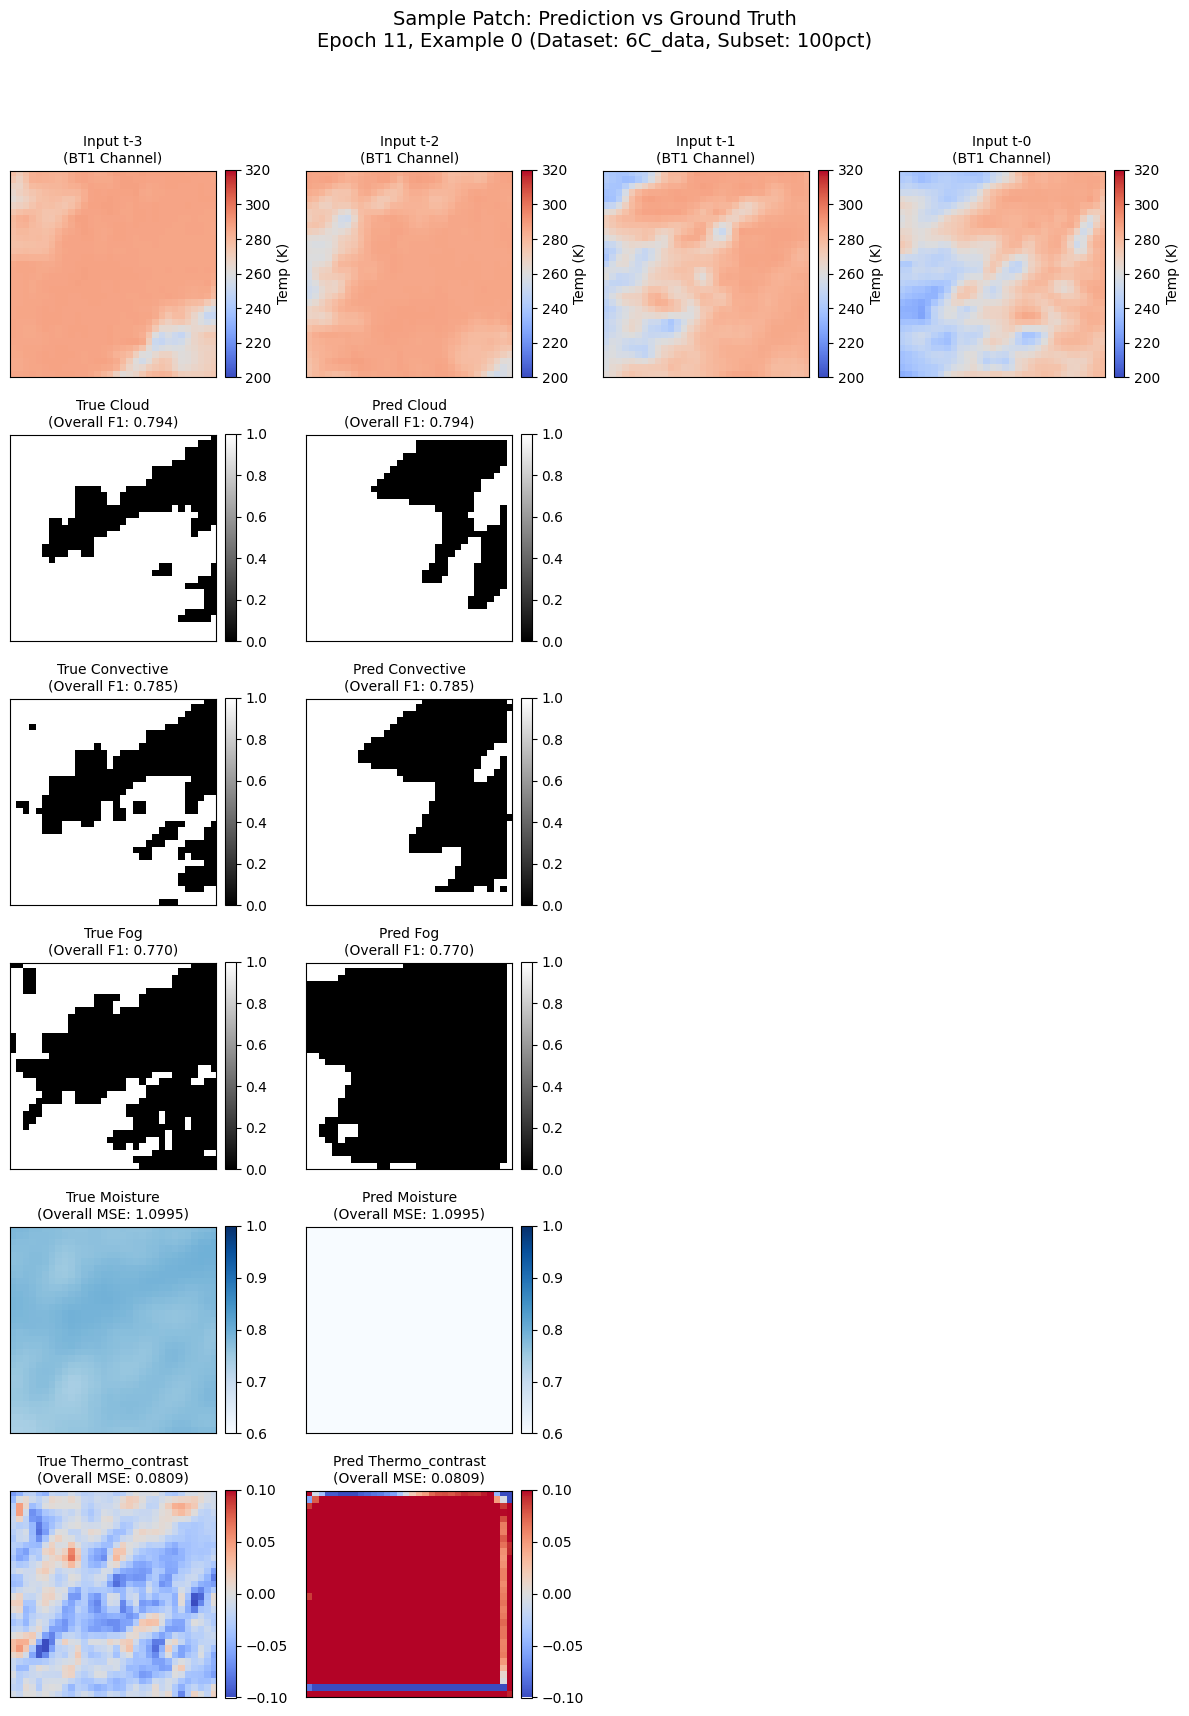


----------------------------------------------------------------------
Description: Sample Prediction vs Ground Truth Plot
  - Checkpoint: model_epoch_11.h5 (Epoch 11)
  - Dataset: '6C_data' (Evaluated on 100pct of validation split)
  - This plot visualizes the model's input and output for a single sample patch.
  - Top Row: Input sequence (BT1 channel, Temperature in Kelvin). t-0 is the latest input.
  - Subsequent Rows: Comparison for each spatial prediction task.
    - Left Column: Ground Truth label for the target time step.
    - Right Column: Model's Prediction for the target time step.
  - Metrics (F1/MSE) in titles are overall scores calculated across the entire evaluation subset.
----------------------------------------------------------------------


[VIS] Attempting to generate Confusion Matrix plot(s)...
      Found valid confusion matrices for: cloud, convective, fog

[VIS] Confusion matrices plot saved successfully to: C:\college\CV\COSMOS\checkpoints\evaluation_confusio

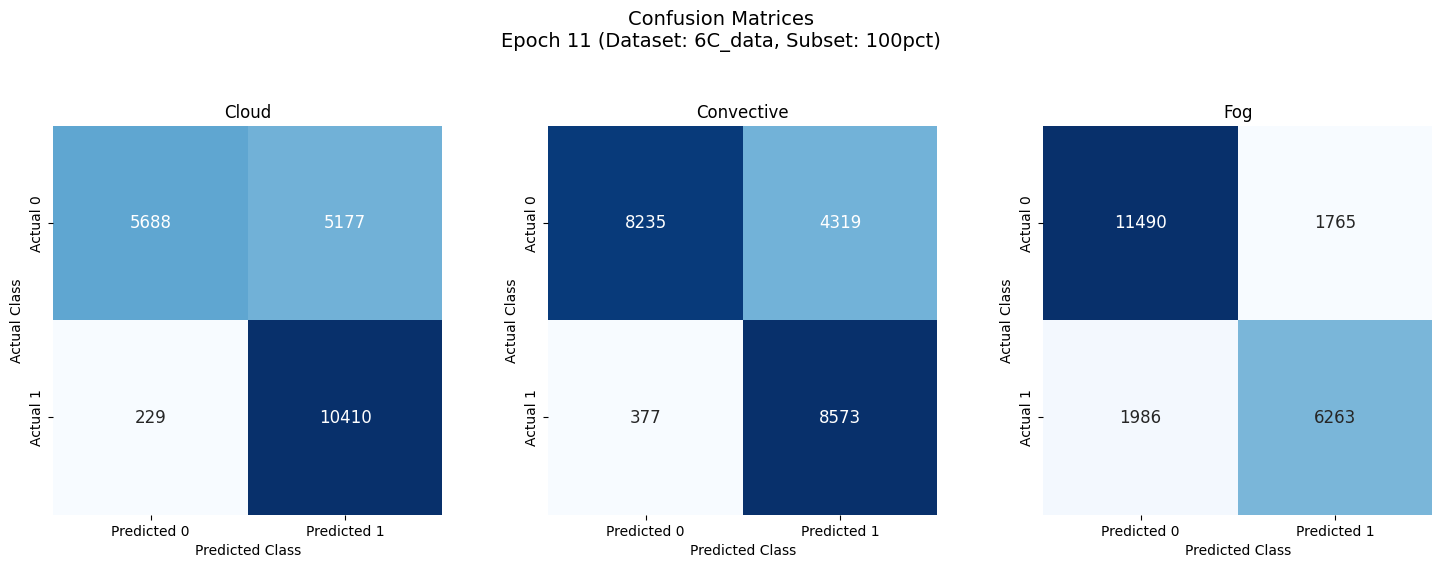


----------------------------------------------------------------------
Description: Confusion Matrix Plot(s)
  - Checkpoint: model_epoch_11.h5 (Epoch 11)
  - Dataset: '6C_data' (Evaluated on 100pct of validation split)
  - Shows classification performance aggregated over the evaluated samples.
  - TN (Top-Left): Correctly predicted Negative (0).
  - FP (Top-Right): Incorrectly predicted Positive (1) (Type I Error).
  - FN (Bottom-Left): Incorrectly predicted Negative (0) (Type II Error).
  - TP (Bottom-Right): Correctly predicted Positive (1).
----------------------------------------------------------------------


[INFO] Evaluation Script Finished at: 2025-05-03 18:14:55


In [5]:
print("\n" + "="*60)
print("[VISUALIZATION] Generating Diagnostic Plots")
print("="*60)

# Only proceed if evaluation was generally successful and we have necessary data
if model is not None and final_metrics and 'error' not in final_metrics and actual_num_samples_for_metrics > 0:

    epoch_str_title = f"Epoch {epoch_number}" if epoch_number != -1 else "Epoch Unknown"
    epoch_str_file = f"epoch_{epoch_number}" if epoch_number != -1 else "epoch_unknown"
    output_dir = os.path.dirname(ckpt_path_to_eval) or '.'
    data_source_marker = os.path.basename(DATA_DIR)
    subset_pct_str_viz = f"{EVAL_SUBSET_FRACTION*100:.0f}pct"

    # --- 1. Generate Sample Prediction vs Ground Truth Plot ---
    print(f"\n[VIS] Attempting to generate Sample Prediction vs Ground Truth plot...")
    try:
        # Get the *first* batch from the evaluation dataset for consistent visualization
        sample_batch = None
        try:
             sample_batch_iterator = iter(eval_ds.take(1))
             sample_batch = next(sample_batch_iterator)
             print("[VIS] Retrieved one sample batch from the dataset.")
        except Exception as e: # Catch StopIteration, OutOfRangeError etc.
             print(f"[WARNING] Could not get a sample batch from dataset: {e}. Skipping sample visualization.")

        if sample_batch:
            x_sample_batch, y_sample_batch = sample_batch
            print(f"[VIS] Generating predictions for the sample batch (for visualization)...")
            pred_sample_batch = model.predict(x_sample_batch, verbose=0)

            idx_in_batch_to_plot = 0 # Visualize the first sample in the batch
            if x_sample_batch.shape[0] > idx_in_batch_to_plot:
                input_patch_sequence = x_sample_batch[idx_in_batch_to_plot].numpy()

                # Identify spatial tasks based on label dictionary structure
                spatial_tasks = [t for t, d in y_sample_batch.items() if d.ndim == 4 and d.shape[1] == PATCH_SIZE]
                num_spatial_tasks = len(spatial_tasks)
                num_input_frames = input_patch_sequence.shape[0]
                num_rows = 1 + num_spatial_tasks # Rows for input + each spatial task
                num_cols = max(num_input_frames, 2) # Columns for input frames and True/Pred comparison

                # --- Create the Sample Figure ---
                fig_width = max(10, 3.0 * num_cols) # Adjusted width scaling
                fig_height = max(4, 3.0 * num_rows)  # Adjusted height scaling
                fig_sample, axes_sample = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), squeeze=False)
                fig_sample.suptitle(f'Sample Patch: Prediction vs Ground Truth\n{epoch_str_title}, Example {idx_in_batch_to_plot} (Dataset: {data_source_marker}, Subset: {subset_pct_str_viz})', fontsize=14)

                # Plot Input Sequence
                print("[VIS] Plotting input sequence patches...")
                for t in range(num_input_frames):
                    ax = axes_sample[0, t]
                    bt1_data = input_patch_sequence[t, ..., 0] * 300.0 # Channel 0 = BT1, approx denormalized
                    im = ax.imshow(bt1_data, cmap='coolwarm', vmin=200, vmax=320) # Adjust range if needed
                    ax.set_title(f'Input t-{num_input_frames-1-t}\n(BT1 Channel)', fontsize=10)
                    ax.set_xticks([]); ax.set_yticks([])
                    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Temp (K)')
                for t in range(num_input_frames, num_cols): axes_sample[0, t].axis('off')

                # Plot True vs Predicted for spatial tasks
                print("[VIS] Plotting True vs Predicted maps for spatial tasks...")
                current_row = 1
                for task_name in spatial_tasks:
                    if task_name not in pred_sample_batch: continue
                    true_map = y_sample_batch[task_name][idx_in_batch_to_plot].numpy()
                    pred_map = pred_sample_batch[task_name][idx_in_batch_to_plot]

                    # Plot settings
                    vmin, vmax, cmap, plot_pred_map = None, None, 'viridis', pred_map
                    task_metric_str = ""
                    if task_name in ['cloud', 'convective', 'fog']:
                        vmin, vmax, cmap = 0, 1, 'gray'
                        plot_pred_map = (pred_map >= 0.5).astype(float)
                        f1_val = final_metrics.get(f'{task_name}_f1', float('nan'))
                        task_metric_str = f'(Overall F1: {f1_val:.3f})'
                    elif task_name == 'moisture':
                        vmin, vmax, cmap = 0.6, 1.0, 'Blues'
                        mse_val = final_metrics.get(f'{task_name}_mse', float('nan'))
                        task_metric_str = f'(Overall MSE: {mse_val:.4f})'
                    elif task_name == 'thermo_contrast':
                        vmin, vmax, cmap = -0.1, 0.1, 'coolwarm'
                        mse_val = final_metrics.get(f'{task_name}_mse', float('nan'))
                        task_metric_str = f'(Overall MSE: {mse_val:.4f})'

                    # Plot True
                    ax_true = axes_sample[current_row, 0]
                    im_true = ax_true.imshow(true_map[..., 0], cmap=cmap, vmin=vmin, vmax=vmax)
                    ax_true.set_title(f'True {task_name.capitalize()}\n{task_metric_str}', fontsize=10)
                    ax_true.set_xticks([]); ax_true.set_yticks([])
                    plt.colorbar(im_true, ax=ax_true, fraction=0.046, pad=0.04)
                    # Plot Predicted
                    ax_pred = axes_sample[current_row, 1]
                    im_pred = ax_pred.imshow(plot_pred_map[..., 0], cmap=cmap, vmin=vmin, vmax=vmax)
                    ax_pred.set_title(f'Pred {task_name.capitalize()}\n{task_metric_str}', fontsize=10)
                    ax_pred.set_xticks([]); ax_pred.set_yticks([])
                    plt.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)
                    # Hide unused columns
                    for c in range(2, num_cols): axes_sample[current_row, c].axis('off')
                    current_row += 1

                # Print Non-Spatial Task Predictions
                non_spatial_tasks = [t for t, d in y_sample_batch.items() if t not in spatial_tasks]
                if non_spatial_tasks:
                    print("\n[VIS] Non-Spatial Task Predictions for this Sample:")
                    for task_name in non_spatial_tasks:
                         if task_name in pred_sample_batch:
                             true_val = y_sample_batch[task_name][idx_in_batch_to_plot].numpy()[0]
                             pred_val = pred_sample_batch[task_name][idx_in_batch_to_plot][0]
                             mae_val = final_metrics.get(f'{task_name}_mae', float('nan'))
                             print(f"      {task_name.capitalize()}: True={true_val:.4f}, Pred={pred_val:.4f} (Overall MAE: {mae_val:.6f})")

                # Finalize and Save Sample Plot
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plot_filename_preds = f"evaluation_sample_pred_vs_true_{data_source_marker}_{epoch_str_file}_subset_{subset_pct_str_viz}.png"
                plot_path_preds = os.path.join(output_dir, plot_filename_preds)
                try:
                    plt.savefig(plot_path_preds, dpi=150, bbox_inches='tight')
                    print(f"\n[VIS] Sample prediction plot saved successfully to: {plot_path_preds}")
                    plt.show()
                except Exception as e: print(f"[ERROR] Failed to save sample prediction plot: {e}")

                # --- Add Description Below Sample Plot ---
                print("\n" + "-" * 70)
                print("Description: Sample Prediction vs Ground Truth Plot")
                print(f"  - Checkpoint: {os.path.basename(ckpt_path_to_eval)} ({epoch_str_title})")
                print(f"  - Dataset: '{data_source_marker}' (Evaluated on {subset_pct_str_viz} of validation split)")
                print(f"  - This plot visualizes the model's input and output for a single sample patch.")
                print(f"  - Top Row: Input sequence (BT1 channel, Temperature in Kelvin). t-0 is the latest input.")
                print(f"  - Subsequent Rows: Comparison for each spatial prediction task.")
                print(f"    - Left Column: Ground Truth label for the target time step.")
                print(f"    - Right Column: Model's Prediction for the target time step.")
                print(f"  - Metrics (F1/MSE) in titles are overall scores calculated across the entire evaluation subset.")
                print("-" * 70 + "\n")


            else: print(f"[WARNING] Sample index {idx_in_batch_to_plot} out of range. Skipping sample plot.")
        # End of sample batch processing block


    except Exception as viz_error:
        print(f"[ERROR] An unexpected error occurred during sample visualization: {viz_error}")
        traceback.print_exc()


    # --- 2. Generate Confusion Matrix Plot(s) ---
    print(f"\n[VIS] Attempting to generate Confusion Matrix plot(s)...")
    try:
        class_tasks_with_cm = [task for task in model.output_names if f'{task}_confusion_matrix' in final_metrics and isinstance(final_metrics[f'{task}_confusion_matrix'], np.ndarray) and final_metrics[f'{task}_confusion_matrix'].shape == (2, 2)]
        num_class_tasks = len(class_tasks_with_cm)

        if num_class_tasks > 0:
            print(f"      Found valid confusion matrices for: {', '.join(class_tasks_with_cm)}")
            # --- Create CM Figure ---
            cm_fig_width = max(5, 5 * num_class_tasks) # Adjusted width
            cm_fig_height = 5.5 # Slightly taller for titles
            fig_cm, axes_cm = plt.subplots(1, num_class_tasks, figsize=(cm_fig_width, cm_fig_height), squeeze=False)
            fig_cm.suptitle(f'Confusion Matrices\n{epoch_str_title} (Dataset: {data_source_marker}, Subset: {subset_pct_str_viz})', fontsize=14)

            for idx, task_name in enumerate(class_tasks_with_cm):
                 cm_data = final_metrics[f'{task_name}_confusion_matrix']
                 ax = axes_cm[0, idx]
                 sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues', ax=ax, square=True,
                             xticklabels=['Predicted 0', 'Predicted 1'],
                             yticklabels=['Actual 0', 'Actual 1'],
                             annot_kws={"size": 12}, cbar=False)
                 ax.set_title(f'{task_name.capitalize()}', fontsize=12)
                 ax.set_ylabel('Actual Class', fontsize=10)
                 ax.set_xlabel('Predicted Class', fontsize=10)

            plt.tight_layout(rect=[0, 0.03, 1, 0.90]) # Adjust rect further for potentially long suptitle
            plot_filename_cm = f"evaluation_confusion_matrices_{data_source_marker}_{epoch_str_file}_subset_{subset_pct_str_viz}.png"
            plot_path_cm = os.path.join(output_dir, plot_filename_cm)
            try:
                 plt.savefig(plot_path_cm, dpi=120, bbox_inches='tight')
                 print(f"\n[VIS] Confusion matrices plot saved successfully to: {plot_path_cm}")
                 plt.show()

                 # --- Add Description Below CM Plot ---
                 print("\n" + "-" * 70)
                 print("Description: Confusion Matrix Plot(s)")
                 print(f"  - Checkpoint: {os.path.basename(ckpt_path_to_eval)} ({epoch_str_title})")
                 print(f"  - Dataset: '{data_source_marker}' (Evaluated on {subset_pct_str_viz} of validation split)")
                 print(f"  - Shows classification performance aggregated over the evaluated samples.")
                 print(f"  - TN (Top-Left): Correctly predicted Negative (0).")
                 print(f"  - FP (Top-Right): Incorrectly predicted Positive (1) (Type I Error).")
                 print(f"  - FN (Bottom-Left): Incorrectly predicted Negative (0) (Type II Error).")
                 print(f"  - TP (Bottom-Right): Correctly predicted Positive (1).")
                 print("-" * 70 + "\n")

            except Exception as e: print(f"[ERROR] Failed to save confusion matrices plot: {e}")
        else:
             print("[INFO] No valid confusion matrix data found for visualization.")

    except Exception as viz_error:
        print(f"[ERROR] An unexpected error occurred during confusion matrix visualization: {viz_error}")
        traceback.print_exc()

# Handle cases where visualization could not run due to prior errors
elif model is None:
    print("[INFO] Skipping visualizations: Model failed to load or MemoryError occurred previously.")
elif 'error' in final_metrics:
     print(f"[INFO] Skipping visualizations due to evaluation error: {final_metrics.get('error', 'Unknown error')}")
elif actual_num_samples_for_metrics <= 0:
    print("[INFO] Skipping visualizations: No aligned samples were available.")
else:
    print("[INFO] Skipping visualizations for an unknown reason.")


print("\n" + "="*60)
print(f"[INFO] Evaluation Script Finished at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)